In [1]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import CountVectorizer, IDF, StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.pipeline import PipelineModel
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.functions import udf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc

In [2]:
# Create SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Classification") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "3g") \
    .config("spark.executor.memoryOverhead", "512m") \
    .config("spark.memory.fraction", "0.8")\
    .config("spark.memory.storageFraction", "0.7")\
    .config("spark.driver.maxResultSize", "1g") \
    .getOrCreate()

24/12/12 19:13:17 WARN Utils: Your hostname, hungnd-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/12/12 19:13:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/12 19:13:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [11]:
# Read data from hdfs
data = spark.read.parquet("hdfs://localhost:9000/final/cleaned_data/")
data.show()
data.printSchema()

+------+---------+---------------+--------------------+-----------+--------------------+--------------------+--------------------+
|ItemID|Sentiment|SentimentSource|       SentimentText|text_length|               words|      filtered_words|    lemmatized_words|
+------+---------+---------------+--------------------+-----------+--------------------+--------------------+--------------------+
|    62|        1|   Sentiment140|i always get what...|         27|[i, always, get, ...| [always, get, want]| [always, get, want]|
|   194|        1|   Sentiment140|tell  i said happ...|         44|[tell, , i, said,...|[tell, , said, ha...|[tell, , said, ha...|
|   436|        0|   Sentiment140|i hope everyone i...|        136|[i, hope, everyon...|[hope, everyone, ...|[hope, everyone, ...|
|   474|        0|   Sentiment140|all my friends ar...|        101|[all, my, friends...|[friends, gone, h...|[friend, gone, ha...|
|   619|        0|   Sentiment140|bcds closed i gue...|         36|[bcds, closed, i

In [12]:
# Prepare data for model
vectorizer = CountVectorizer(inputCol="lemmatized_words", outputCol="raw_features", maxDF=0.8, minDF=5)
idf = IDF(inputCol="raw_features", outputCol="features")
data = data.drop("ItemID", "SentimentSource", "SentimentText", "text_length", "words", "filtered_words")
data.show()

# Split train/test dataset
train_data, test_data = data.randomSplit([0.9, 0.1], seed=42)

# Metrics
acc_evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="f1")

+---------+--------------------+
|Sentiment|    lemmatized_words|
+---------+--------------------+
|        1| [always, get, want]|
|        1|[tell, , said, ha...|
|        0|[hope, everyone, ...|
|        0|[friend, gone, ha...|
|        0|[bcds, closed, gu...|
|        0|[want, buy, sims,...|
|        0|[damn, something,...|
|        1|[posterous, look,...|
|        1|                  []|
|        0|       [hiccuuppsss]|
|        0|[guess, wouldnt, ...|
|        0|[hope, justice, i...|
|        0|[miss, guild, war...|
|        1|[finishing, midte...|
|        1|[fresh, shower, w...|
|        0|       [leave, soon]|
|        0|[beeeeen, sayin, ...|
|        0|[cant, get, ma, r...|
|        0|[feel, like, frea...|
|        0|[still, waiting, ...|
+---------+--------------------+
only showing top 20 rows



In [ ]:
# Naive Bayes
nb = NaiveBayes(featuresCol="features", labelCol="Sentiment", smoothing=1.0, modelType="multinomial")

pipeline = Pipeline(stages=[vectorizer, idf, nb])

nb_model = pipeline.fit(train_data)

nb_predictions = nb_model.transform(test_data)

nb_accuracy = acc_evaluator.evaluate(nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")

nb_f1 = f1_evaluator.evaluate(nb_predictions)
print(f"Naive Bayes F1 Score: {nb_f1:.4f}")

# Save model to hdfs
nb_model.save("hdfs://localhost:9000/model/nb")

In [5]:
# Loading the saved Naive Bayes model from HDFS for reuse.
nb_model = PipelineModel.load("hdfs://localhost:9000/model/nb")
nb_predictions = nb_model.transform(test_data)

nb_accuracy = acc_evaluator.evaluate(nb_predictions)
nb_f1 = f1_evaluator.evaluate(nb_predictions)

print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print(f"Naive Bayes F1 Score: {nb_f1:.4f}")

24/12/12 19:14:01 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
24/12/12 19:14:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/12 19:14:06 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


Naive Bayes Accuracy: 0.8015
Naive Bayes F1 Score: 0.8015


/home/hungnd/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/12/12 19:14:18 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
24/12/12 19:14:18 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
24/12/12 19:14:21 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


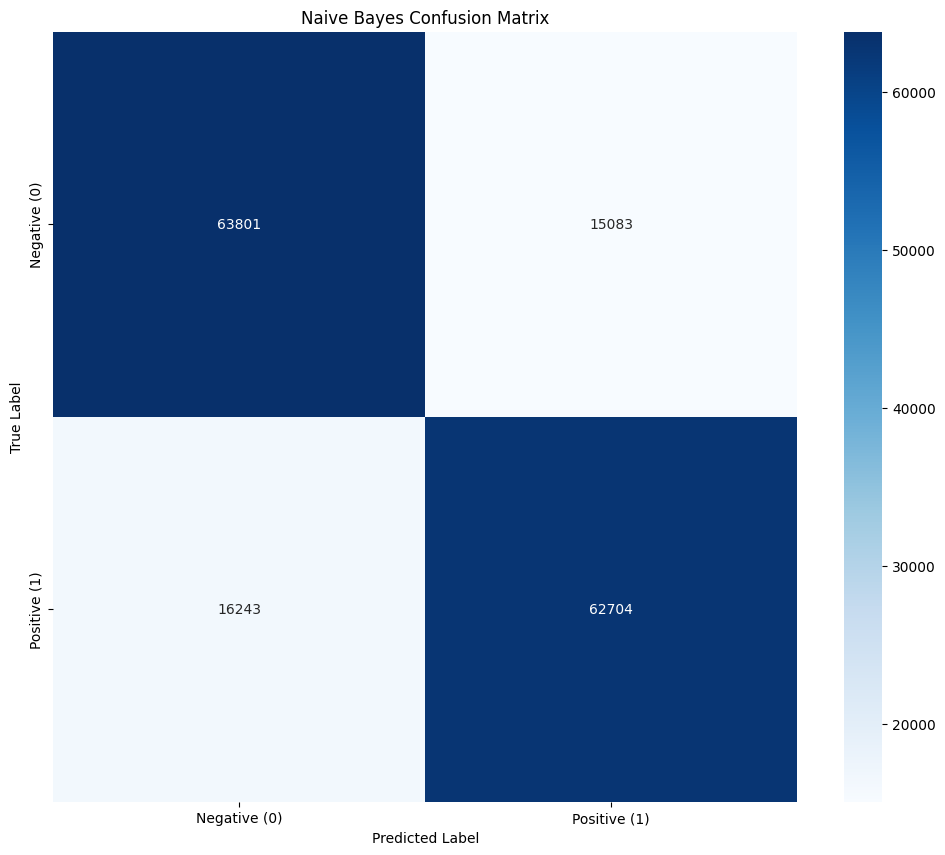

In [6]:
# Naive Bayes Confusion Matrix
predictionAndLabels = nb_predictions.select("prediction", "Sentiment").rdd.map(lambda row: (float(row[0]), float(row[1])))

metrics = MulticlassMetrics(predictionAndLabels)
cm = metrics.confusionMatrix().toArray()
cm_df = pd.DataFrame(cm, index=["Negative (0)", "Positive (1)"], columns=["Negative (0)", "Positive (1)"])

plt.figure(figsize=(12,10))
sns.heatmap(cm_df, annot=True, fmt=".0f", cmap="Blues")
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="Sentiment", maxIter=20, regParam=0.3, elasticNetParam=0)

lr_pipeline = Pipeline(stages=[vectorizer, idf, lr])

lr_model = lr_pipeline.fit(train_data)

lr_predictions = lr_model.transform(test_data)

lr_accuracy = acc_evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

lr_f1 = f1_evaluator.evaluate(lr_predictions)
print(f"Logistic Regression F1 Score: {lr_f1:.4f}")

# Save model to hdfs
lr_model.save("hdfs://localhost:9000/model/lr")

In [7]:
# Loading the saved Logistic Regression model from HDFS for reuse.
lr_model = PipelineModel.load("hdfs://localhost:9000/model/lr")
lr_predictions = lr_model.transform(test_data)


lr_accuracy = acc_evaluator.evaluate(lr_predictions)
lr_f1 = f1_evaluator.evaluate(lr_predictions)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Logistic Regression F1 Score: {lr_f1:.4f}")

24/12/12 19:14:39 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
24/12/12 19:14:43 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


Logistic Regression Accuracy: 0.8187
Logistic Regression F1 Score: 0.8187


/home/hungnd/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/12/12 19:15:14 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
24/12/12 19:15:14 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
24/12/12 19:15:17 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


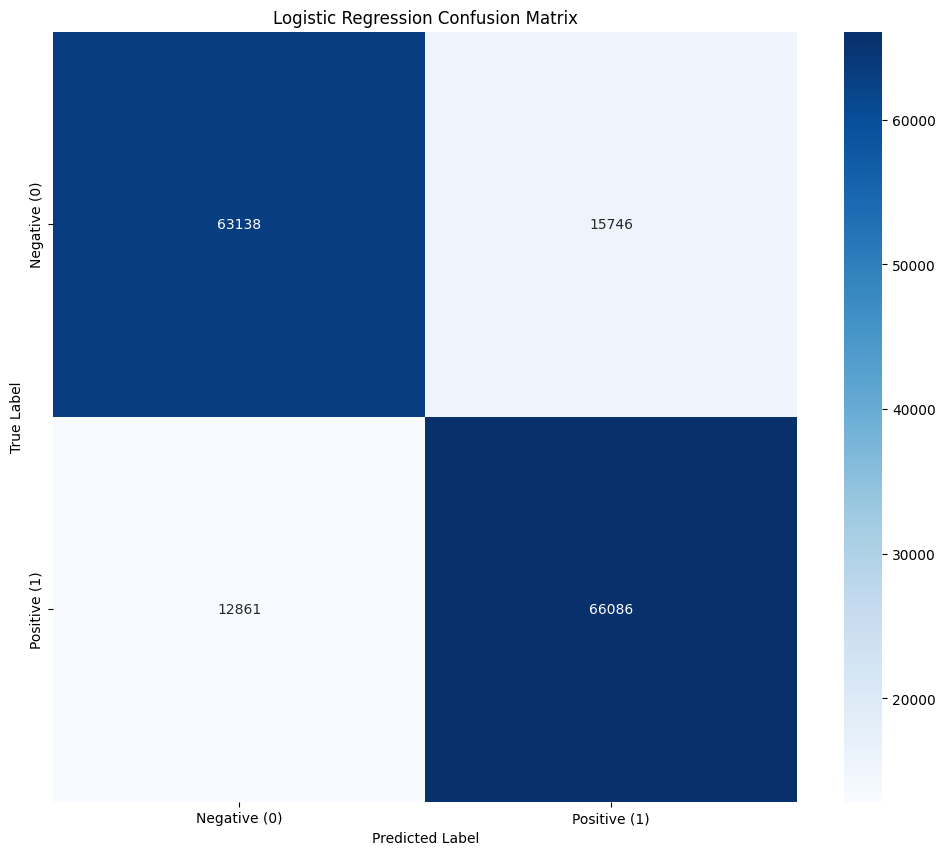

In [ ]:
# Logistic Regression Confusion Matrix
predictionAndLabels = lr_predictions.select("prediction", "Sentiment").rdd.map(lambda row: (float(row[0]), float(row[1])))

metrics = MulticlassMetrics(predictionAndLabels)
cm = metrics.confusionMatrix().toArray()
cm_df = pd.DataFrame(cm, index=["Negative (0)", "Positive (1)"], columns=["Negative (0)", "Positive (1)"])

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt=".0f", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=40, maxDepth=5, maxBins=64)

rf_pipeline = Pipeline(stages=[vectorizer, idf, rf])

rf_model = rf_pipeline.fit(train_data)

rf_predictions = rf_model.transform(test_data)

rf_accuracy = acc_evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

rf_f1 = f1_evaluator.evaluate(rf_predictions)
print(f"Random Forest F1 Score: {rf_f1:.4f}")

# Save model to hdfs
rf_model.save("hdfs://localhost:9000/model/rf")

In [14]:
# Loading the saved Random Forest model from HDFS for reuse.
rf_model = PipelineModel.load("hdfs://localhost:9000/model/rf")
rf_predictions = rf_model.transform(test_data)

rf_accuracy = acc_evaluator.evaluate(rf_predictions)
rf_f1 = f1_evaluator.evaluate(rf_predictions)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest F1 Score: {rf_f1:.4f}")

24/12/12 19:17:03 WARN DAGScheduler: Broadcasting large task binary with size 1439.8 KiB
24/12/12 19:17:07 WARN DAGScheduler: Broadcasting large task binary with size 1439.8 KiB


Random Forest Accuracy: 0.6535
Random Forest F1 Score: 0.6461


/home/hungnd/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/12/12 19:17:13 WARN DAGScheduler: Broadcasting large task binary with size 1426.4 KiB
24/12/12 19:17:13 WARN DAGScheduler: Broadcasting large task binary with size 1426.4 KiB
24/12/12 19:17:15 WARN DAGScheduler: Broadcasting large task binary with size 1438.1 KiB


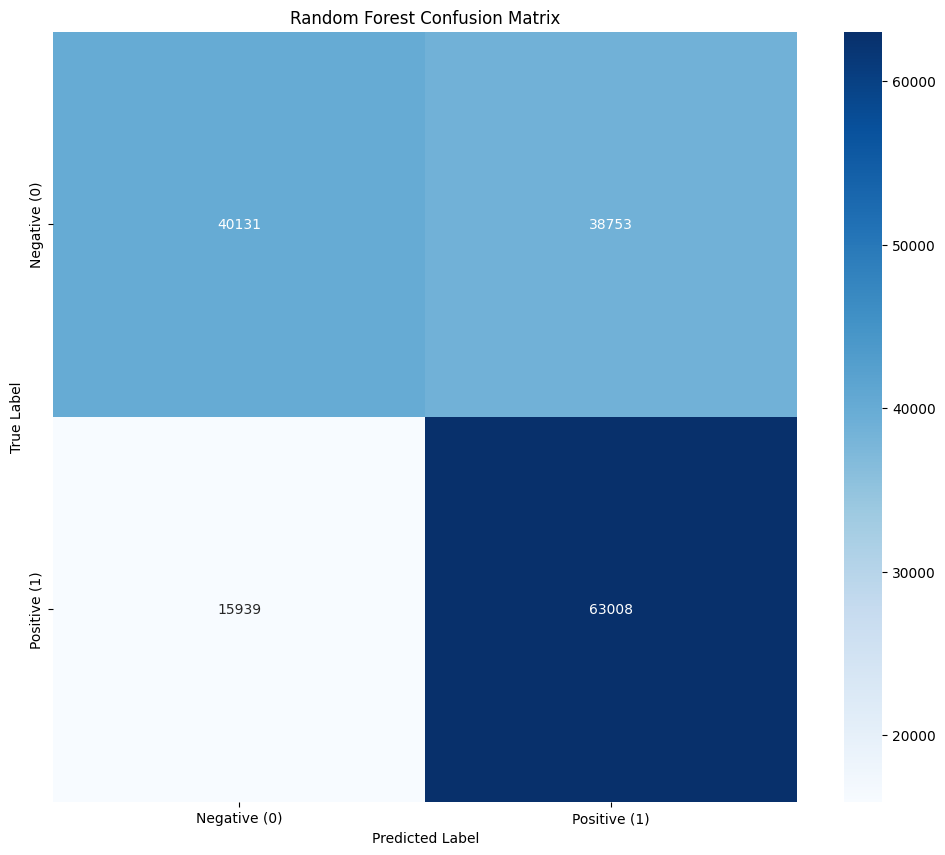

In [15]:
# Random Forest Confusion Matrix
predictionAndLabels = rf_predictions.select("prediction", "Sentiment").rdd.map(lambda row: (float(row[0]), float(row[1])))

metrics = MulticlassMetrics(predictionAndLabels)
cm = metrics.confusionMatrix().toArray()
cm_df = pd.DataFrame(cm, index=["Negative (0)", "Positive (1)"], columns=["Negative (0)", "Positive (1)"])

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt=".0f", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()